In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [16]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 116]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [17]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/sagittal/t1c", t2f_dir="PED_Sliced/sagittal/t2f", seg_dir="PED_Sliced/sagittal/seg", transforms=data_transforms)

In [18]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

In [19]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



6389
267
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])


In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        # up6 = self.up6(c5)
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [21]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [22]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [23]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_PED_sagittal.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_PED_sagittal.pth")

    
    return model


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


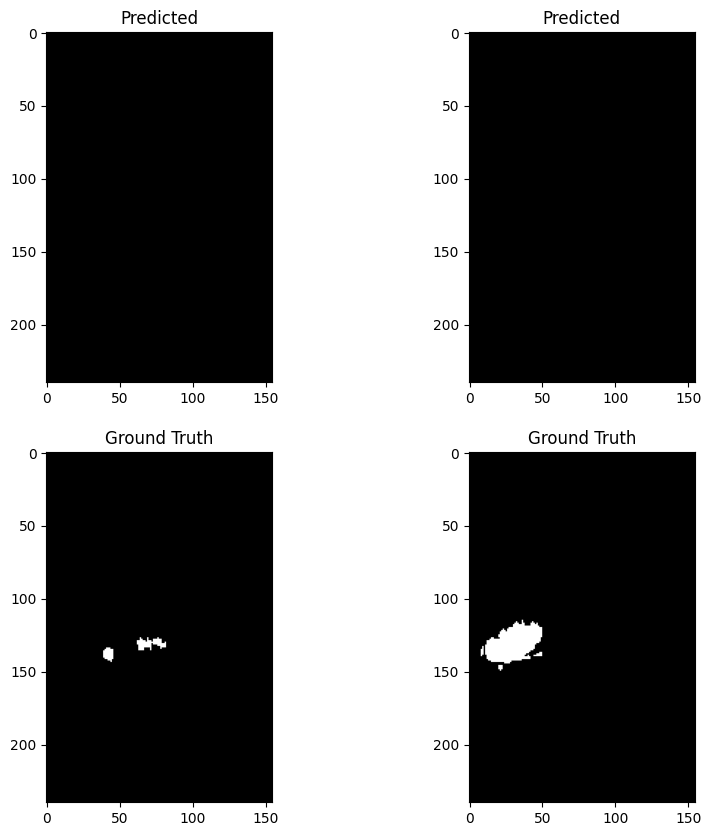

100%|██████████| 267/267 [03:53<00:00,  1.14it/s]



Average Training Loss: 0.23003769734323248

Average Training DSC: [0.92866399 0.40363894 0.78127341 0.00334417]
Average Training ASSD: [ 19.76291517 192.81254686  79.17902622 356.91555623]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


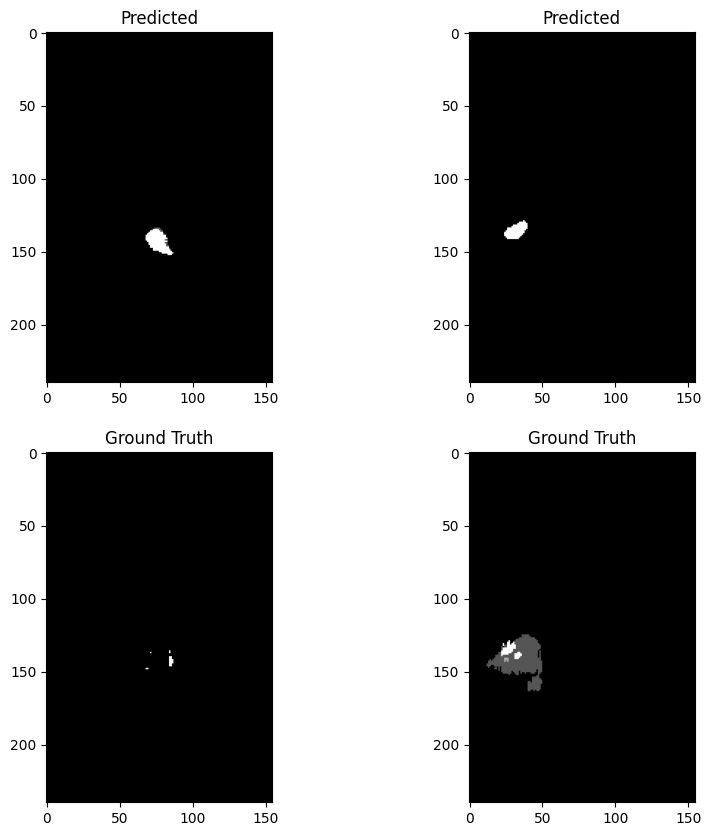

100%|██████████| 67/67 [00:34<00:00,  1.94it/s]


Average Validation Loss: 0.07126324356936697

Average Validation DSC: [0.98928819 0.38360247 0.77203269 0.17399742]
Average Validation ASSD: [  1.64047977 157.22689179  82.52416489 150.60885834]
Epoch 2/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


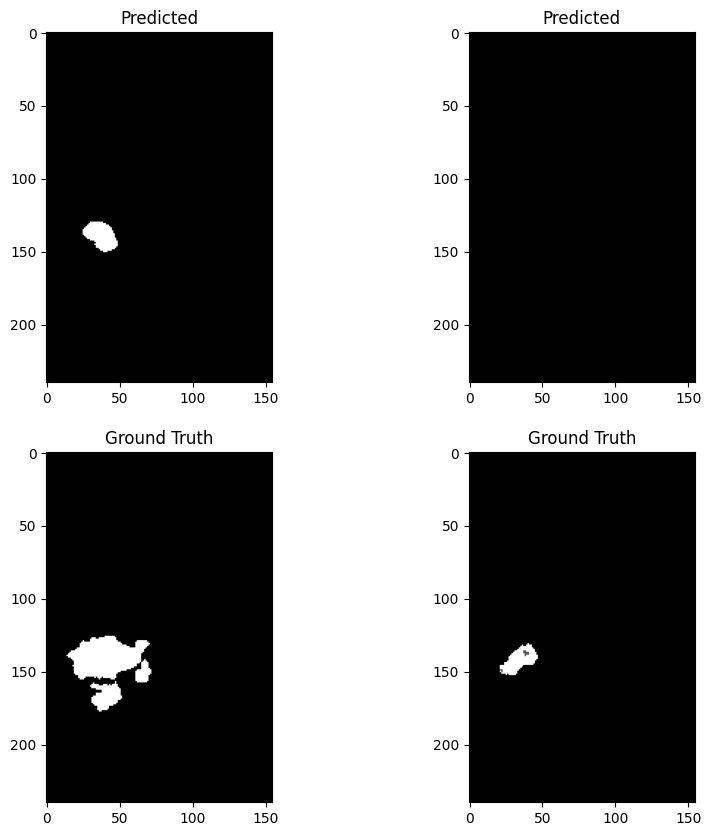

100%|██████████| 267/267 [04:10<00:00,  1.07it/s]



Average Training Loss: 0.06550291015972359

Average Training DSC: [0.9924162  0.39524457 0.78186642 0.22630872]
Average Training ASSD: [  0.95748595 148.7497262   78.96435705  88.28385181]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


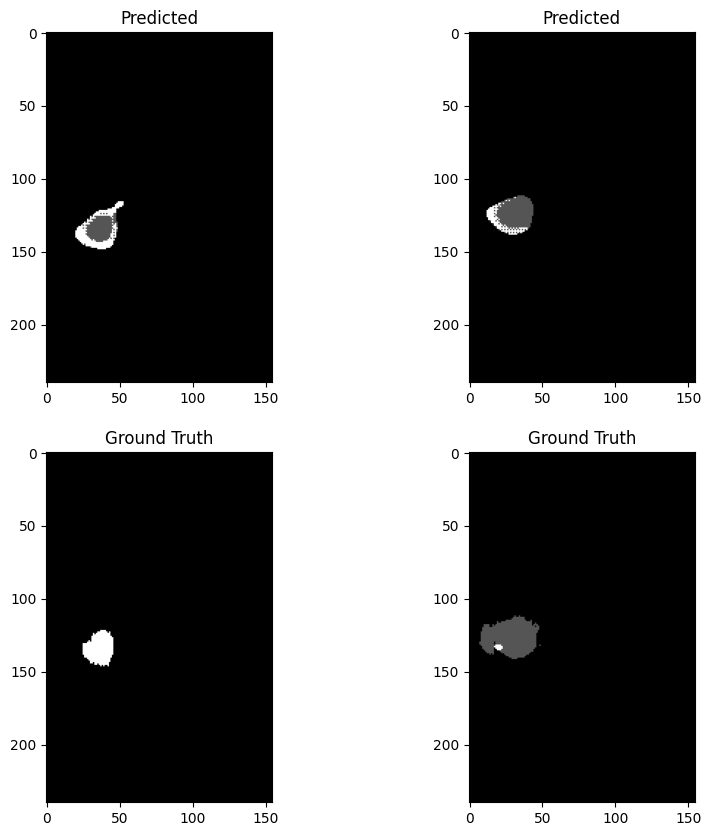

100%|██████████| 67/67 [00:39<00:00,  1.71it/s]


Average Validation Loss: 0.056731428728619616

Average Validation DSC: [0.99472844 0.43579801 0.77203269 0.24495636]
Average Validation ASSD: [  0.58971934 119.19714157  82.52416489  46.07567787]
Epoch 3/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


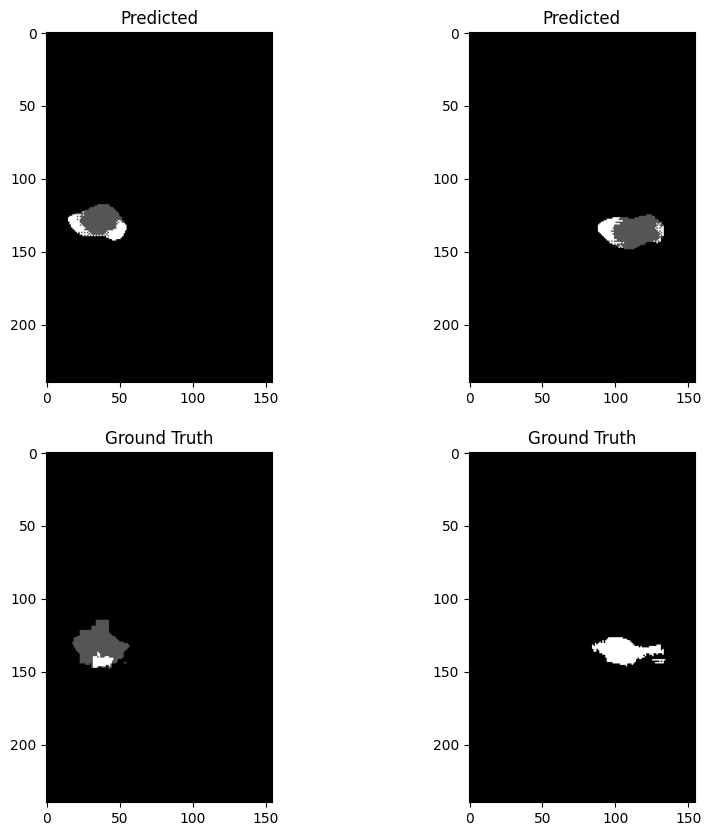

100%|██████████| 267/267 [04:14<00:00,  1.05it/s]



Average Training Loss: 0.055229477158813885

Average Training DSC: [0.99415097 0.41941398 0.78245943 0.3005774 ]
Average Training ASSD: [  0.72195693 131.88654085  78.74968789  74.34250149]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


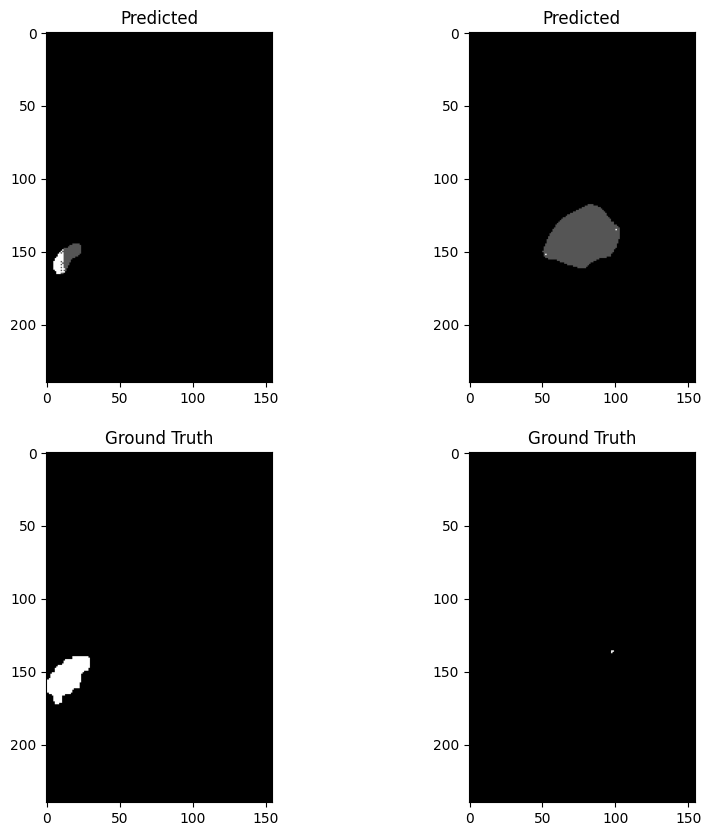

100%|██████████| 67/67 [00:37<00:00,  1.80it/s]


Average Validation Loss: 0.052849660558042244

Average Validation DSC: [0.99541865 0.41183326 0.7724769  0.16866561]
Average Validation ASSD: [  0.525268   133.95210465  82.36336176  79.07858557]
Epoch 4/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


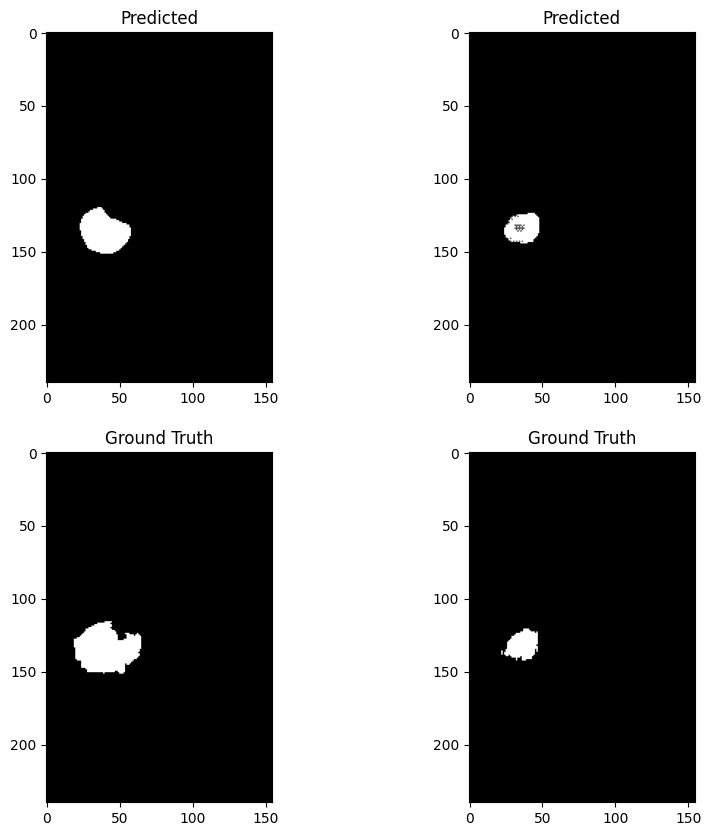

100%|██████████| 267/267 [04:14<00:00,  1.05it/s]



Average Training Loss: 0.0492959584594331

Average Training DSC: [0.99519487 0.41251352 0.78245943 0.3189862 ]
Average Training ASSD: [  0.58606603 124.57200093  78.74968789  63.19491263]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


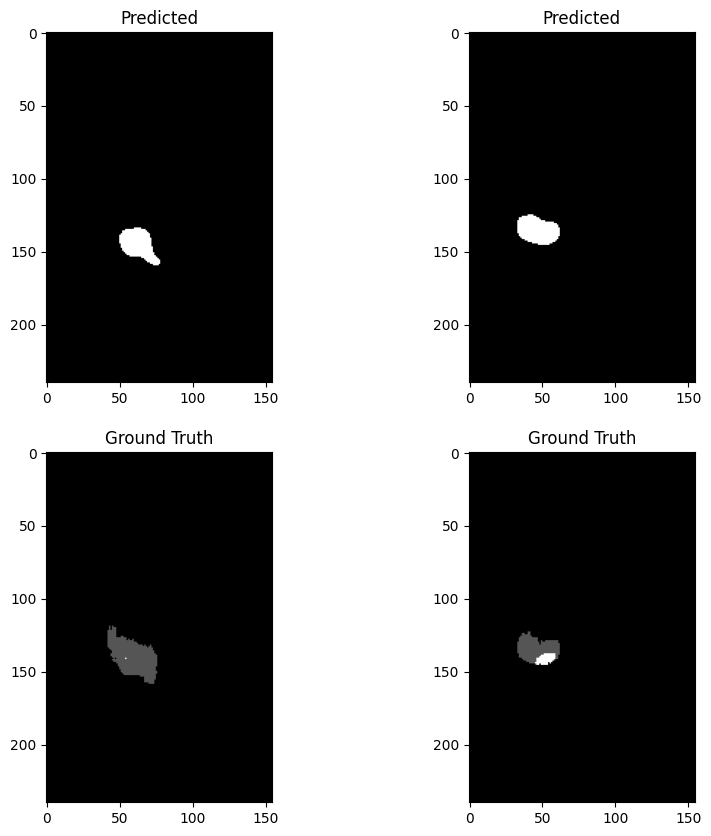

100%|██████████| 67/67 [00:35<00:00,  1.89it/s]


Average Validation Loss: 0.04487391236001876

Average Validation DSC: [0.99590455 0.42035792 0.77203269 0.40664952]
Average Validation ASSD: [  0.46961754 129.76758202  82.52416489  41.45944189]
Epoch 5/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


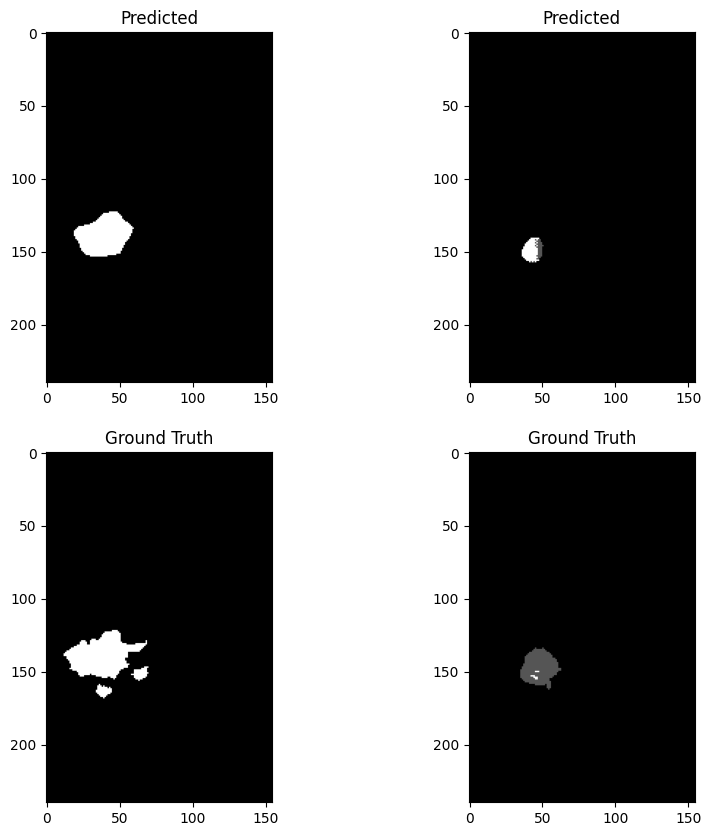

100%|██████████| 267/267 [04:09<00:00,  1.07it/s]



Average Training Loss: 0.04421441796957777

Average Training DSC: [0.99603297 0.39751592 0.78245943 0.34426495]
Average Training ASSD: [  0.47668891 130.92116031  78.74968789  56.78105993]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


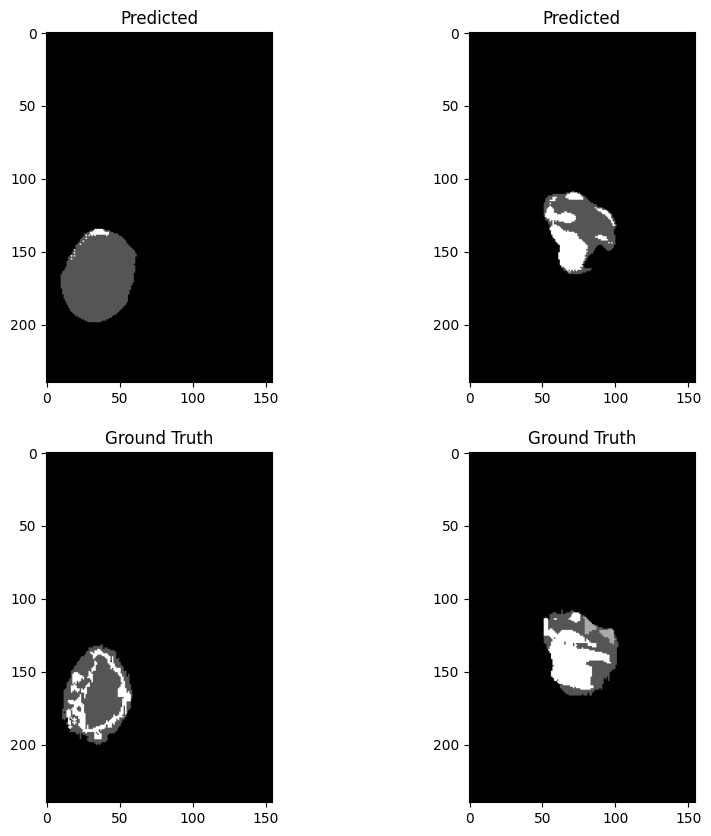

100%|██████████| 67/67 [00:35<00:00,  1.88it/s]


Average Validation Loss: 0.040745602253435265

Average Validation DSC: [0.99677602 0.44389738 0.7724769  0.12539263]
Average Validation ASSD: [  0.37001901 134.74336003  82.36336176 138.0904109 ]
Epoch 6/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


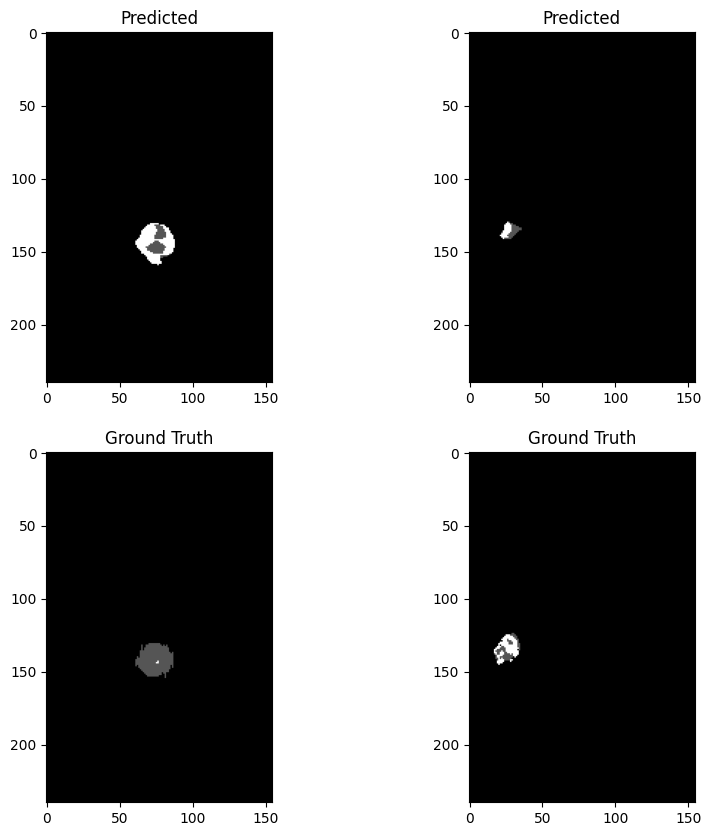

100%|██████████| 267/267 [04:16<00:00,  1.04it/s]



Average Training Loss: 0.040618918661711814

Average Training DSC: [0.99641827 0.40457571 0.77972379 0.33007816]
Average Training ASSD: [  0.4277011  127.47855969  72.56354926  64.42618203]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


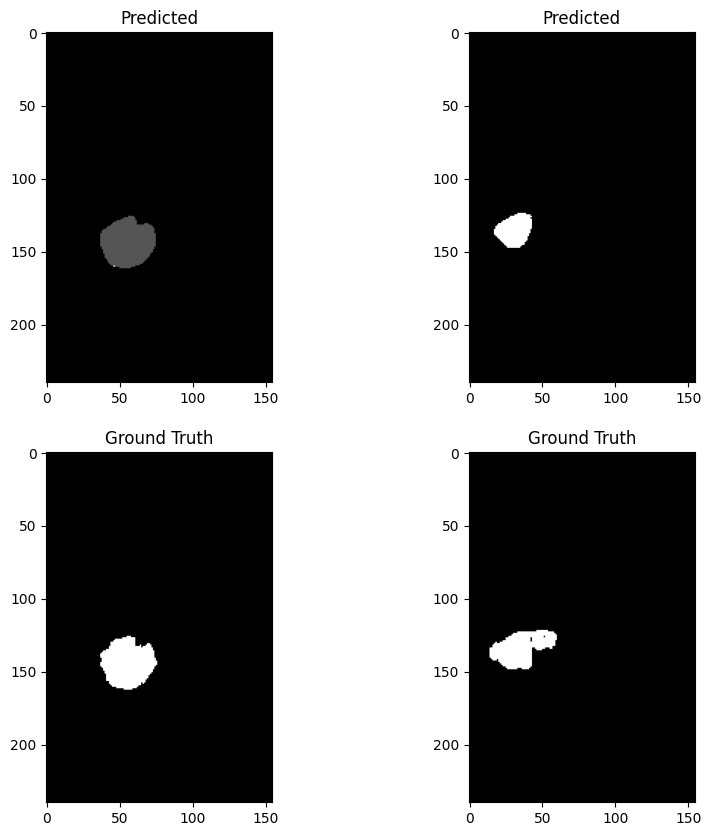

100%|██████████| 67/67 [00:36<00:00,  1.82it/s]


Average Validation Loss: 0.036896031989312884

Average Validation DSC: [0.99697691 0.4689867  0.73476801 0.22994454]
Average Validation ASSD: [  0.35381672 121.25940973  68.33403337  90.43827399]
Epoch 7/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


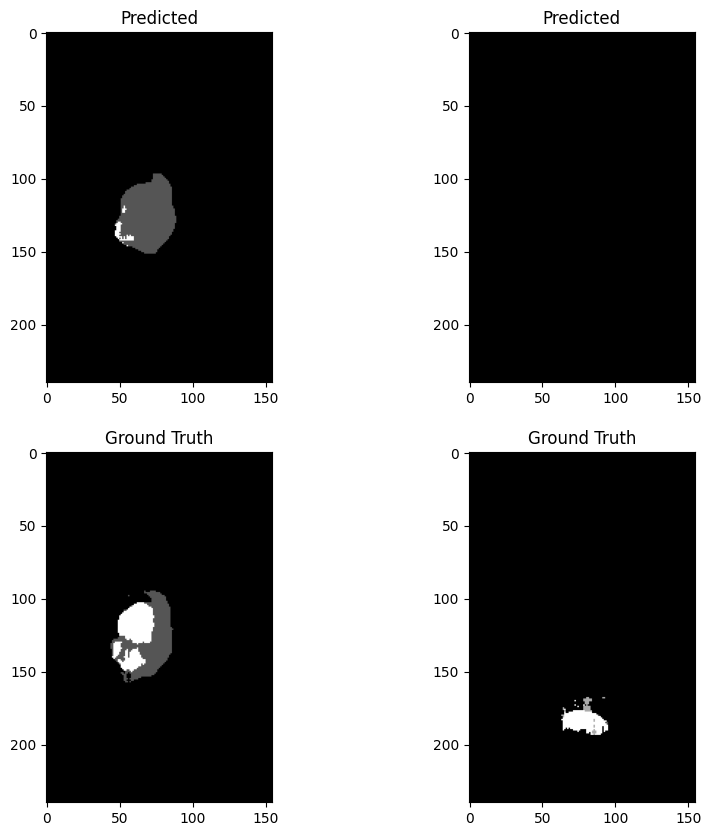

100%|██████████| 267/267 [04:13<00:00,  1.05it/s]



Average Training Loss: 0.03634839787493261

Average Training DSC: [0.99670757 0.43878096 0.76863735 0.33680595]
Average Training ASSD: [  0.38519468 121.76986155  58.79283087  71.21744117]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


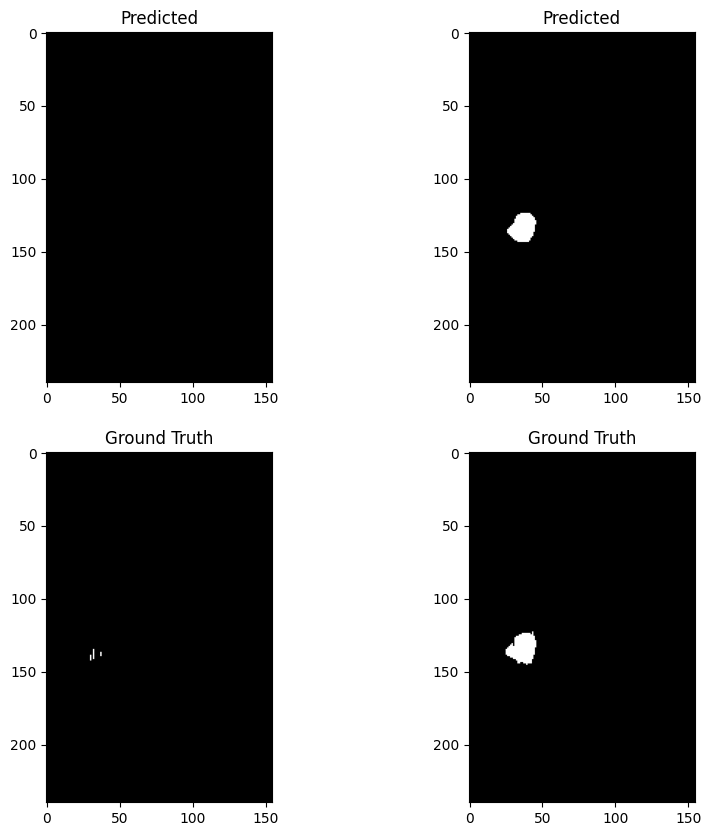

100%|██████████| 67/67 [00:37<00:00,  1.77it/s]


Average Validation Loss: 0.03266995494712645

Average Validation DSC: [0.99705711 0.5189038  0.79732107 0.36311218]
Average Validation ASSD: [ 0.36070011 98.15500966 50.17738311 59.53562964]
Epoch 8/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


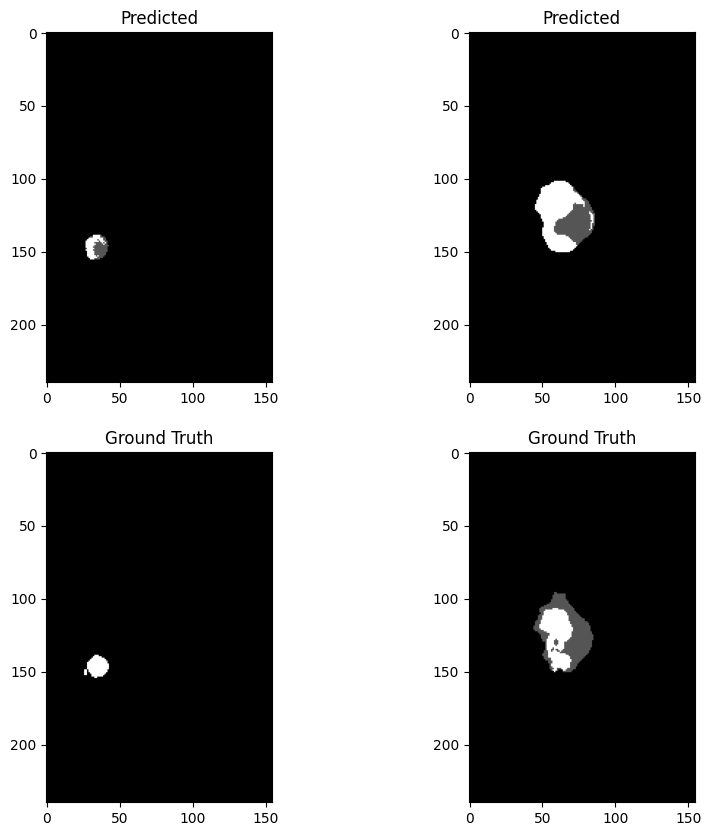

100%|██████████| 267/267 [05:30<00:00,  1.24s/it]



Average Training Loss: 0.03195785107753808

Average Training DSC: [0.99715575 0.47951255 0.81002579 0.37012565]
Average Training ASSD: [  0.32483005 113.45368122  48.45952869  59.11634535]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


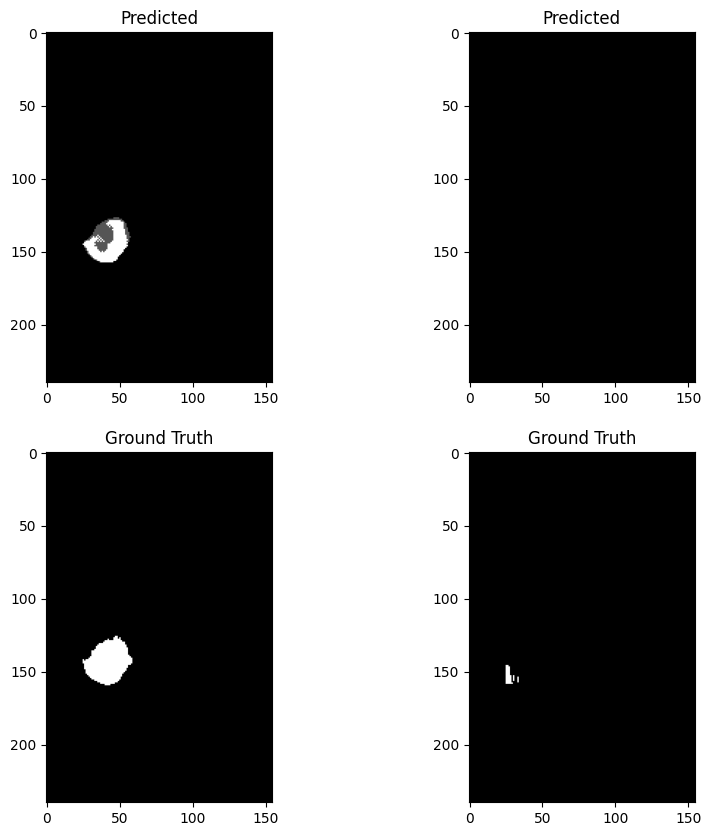

100%|██████████| 67/67 [01:15<00:00,  1.13s/it]


Average Validation Loss: 0.029192301736616376

Average Validation DSC: [0.99749916 0.5246491  0.84099235 0.3897429 ]
Average Validation ASSD: [  0.28994538 100.22481078  40.55970458  51.90990404]
Epoch 9/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


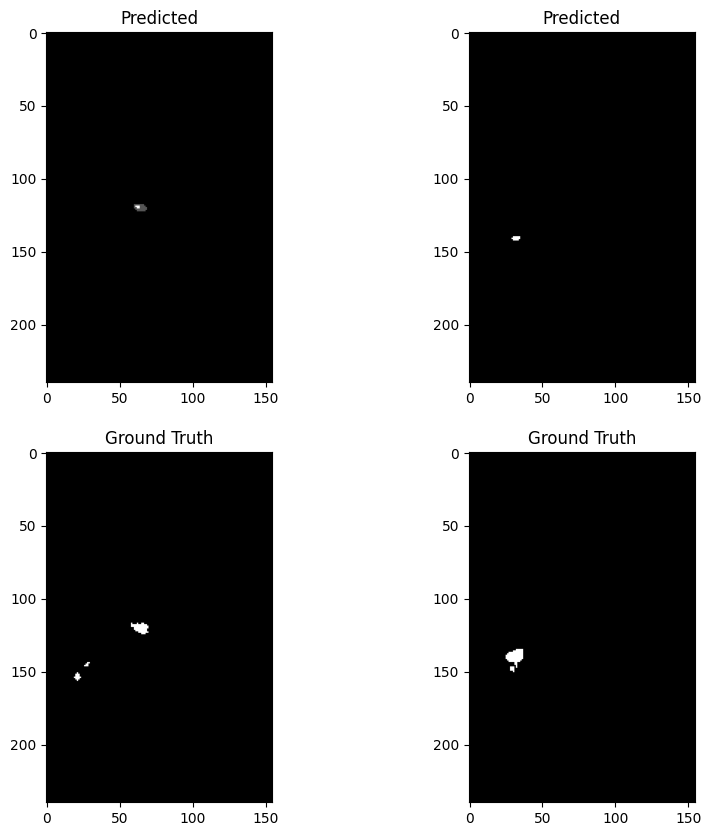

100%|██████████| 267/267 [06:53<00:00,  1.55s/it]



Average Training Loss: 0.028755447028504775

Average Training DSC: [0.99740049 0.5388547  0.82743338 0.41537575]
Average Training ASSD: [  0.29165771 102.44895197  43.37800827  47.72247366]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


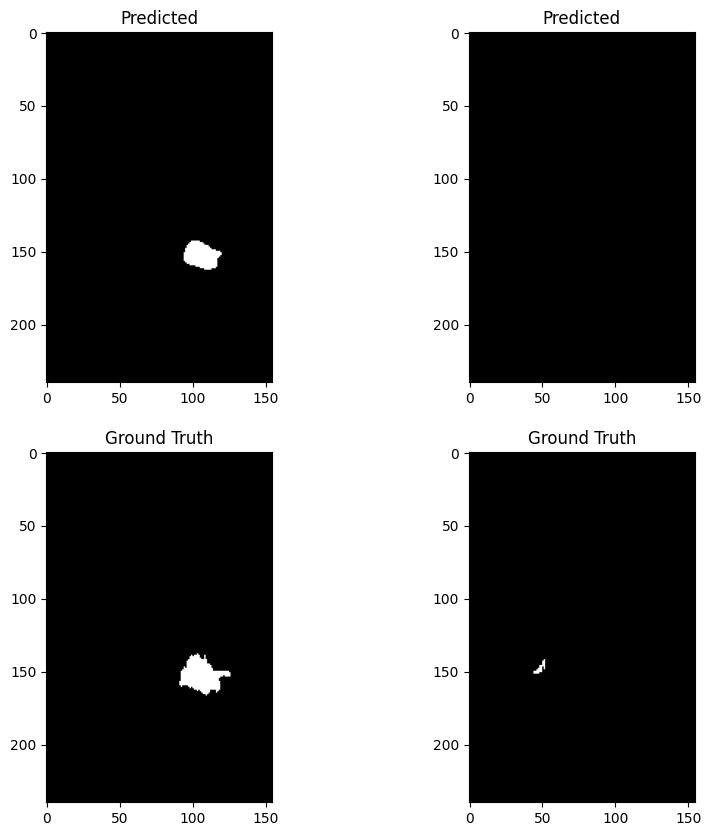

100%|██████████| 67/67 [01:33<00:00,  1.39s/it]


Average Validation Loss: 0.02676744823024344

Average Validation DSC: [0.99750248 0.60932563 0.84133004 0.46190926]
Average Validation ASSD: [ 0.29250637 78.18969049 38.28664344 45.99530956]
Epoch 10/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


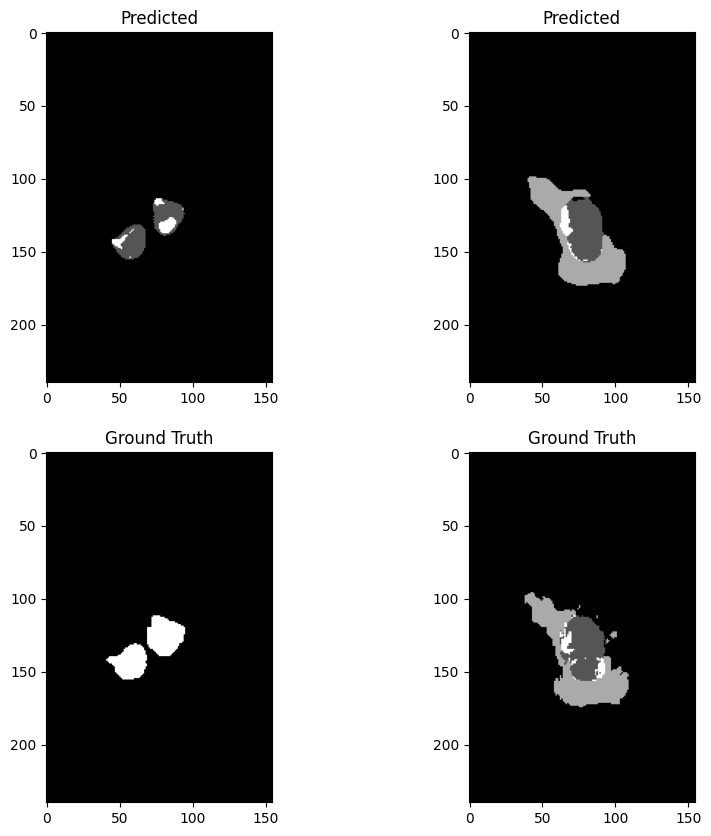

100%|██████████| 267/267 [07:27<00:00,  1.68s/it]



Average Training Loss: 0.025996145160959456

Average Training DSC: [0.9975296  0.62960981 0.8386478  0.46125627]
Average Training ASSD: [ 0.27308375 78.8946436  40.58138283 47.60137965]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


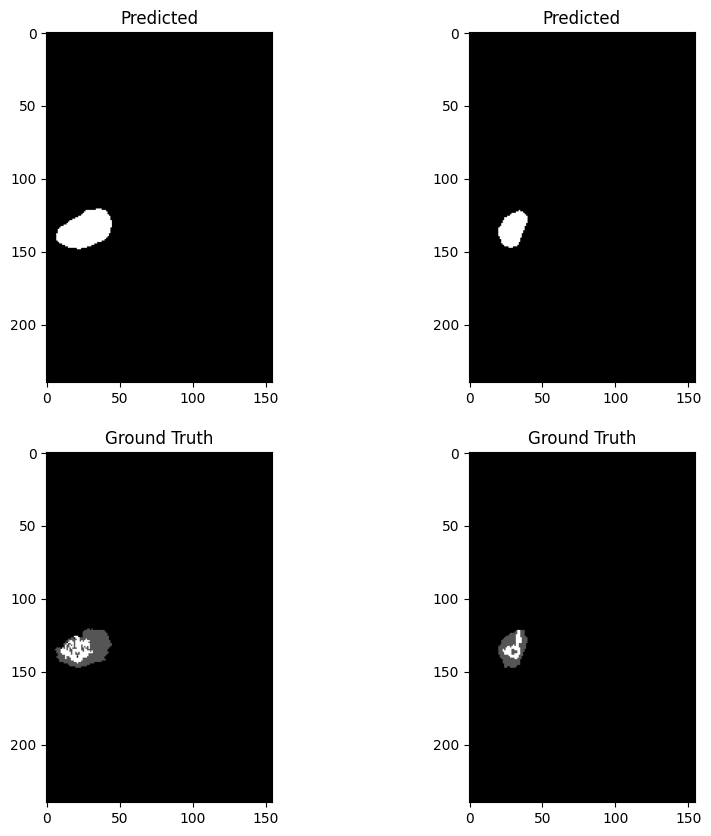

100%|██████████| 67/67 [01:19<00:00,  1.19s/it]


Average Validation Loss: 0.023949530740171227

Average Validation DSC: [0.99769656 0.66547935 0.83114884 0.42738405]
Average Validation ASSD: [ 0.27847608 75.08103404 42.88710588 76.67491296]
Epoch 11/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


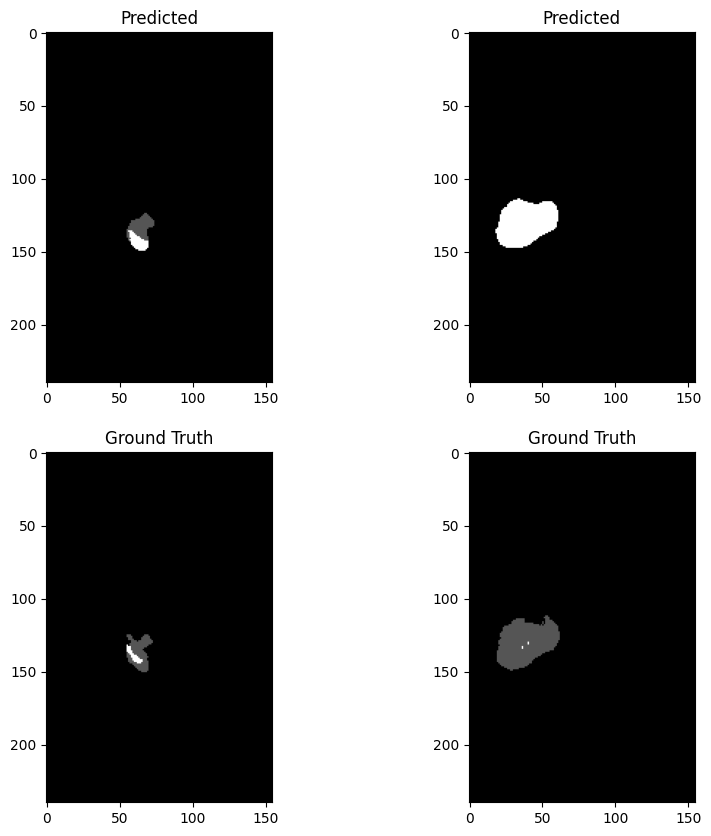

100%|██████████| 267/267 [09:52<00:00,  2.22s/it]



Average Training Loss: 0.02331741622645645

Average Training DSC: [0.99766092 0.70397117 0.85515565 0.50136282]
Average Training ASSD: [ 0.25407557 58.0319632  34.24196678 52.53416212]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


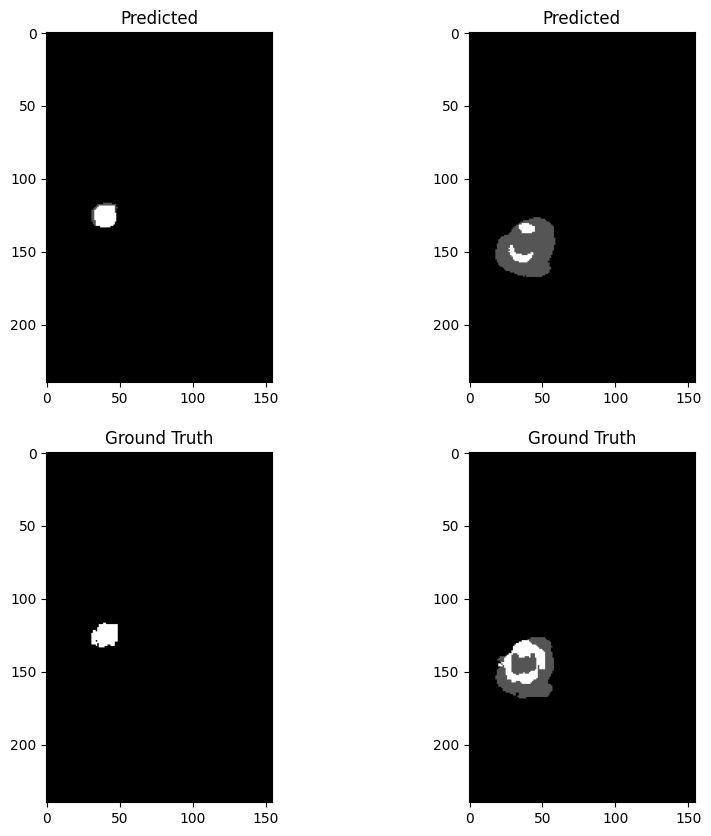

100%|██████████| 67/67 [02:41<00:00,  2.42s/it]


Average Validation Loss: 0.02326755142256395

Average Validation DSC: [0.99782862 0.70735323 0.85917264 0.39495803]
Average Validation ASSD: [ 0.24530984 62.81902469 34.64826866 96.0316086 ]
Epoch 12/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


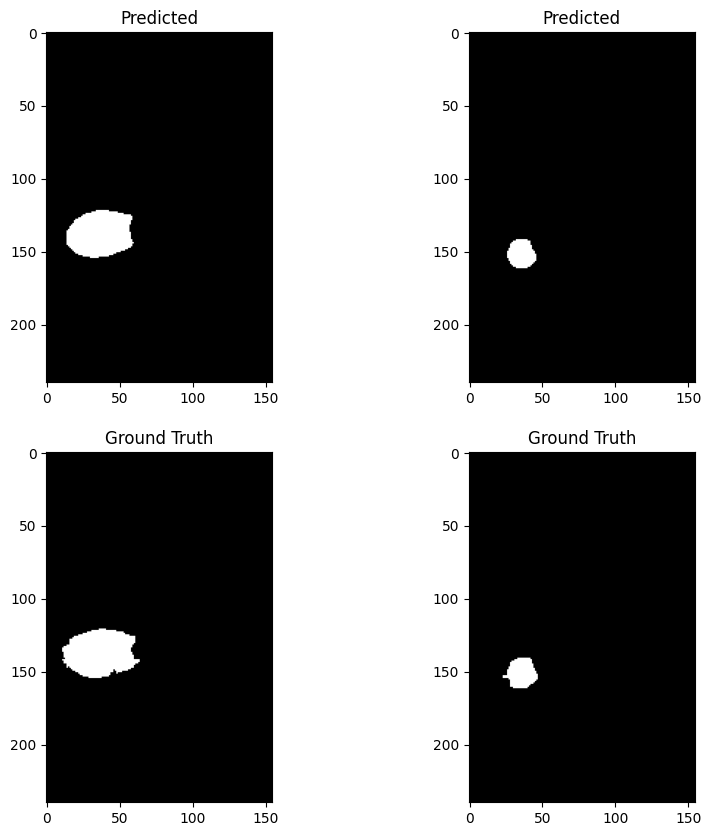

100%|██████████| 267/267 [11:30<00:00,  2.58s/it]



Average Training Loss: 0.021462145460288178

Average Training DSC: [0.99781637 0.74140087 0.87272013 0.52086371]
Average Training ASSD: [ 0.23722775 48.60711282 27.94261042 57.5500127 ]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


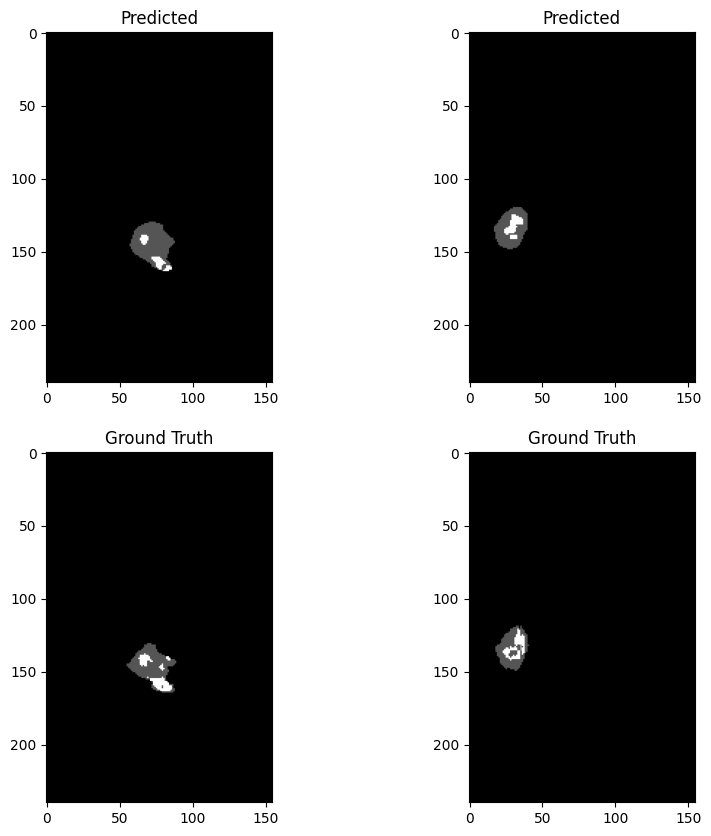

100%|██████████| 67/67 [02:31<00:00,  2.26s/it]


Average Validation Loss: 0.021583119754804606

Average Validation DSC: [0.99772365 0.77275836 0.83265011 0.46840713]
Average Validation ASSD: [ 0.25328603 39.50547966 41.47590726 69.02562627]
Epoch 13/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


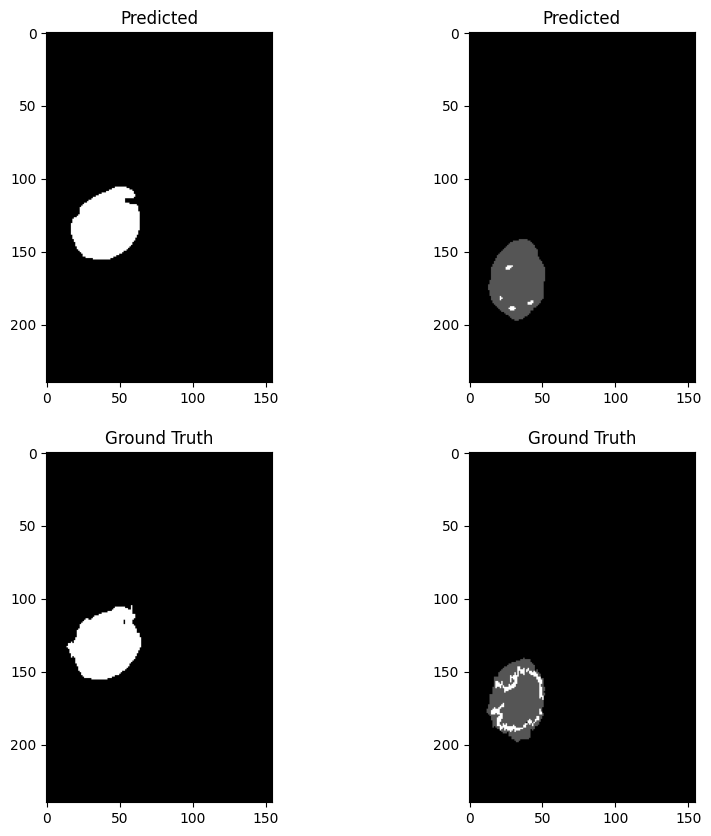

100%|██████████| 267/267 [11:22<00:00,  2.56s/it]



Average Training Loss: 0.019336284923084666

Average Training DSC: [0.99793994 0.78164332 0.88039178 0.5481683 ]
Average Training ASSD: [ 0.21722014 37.38810652 25.09880851 55.33557291]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


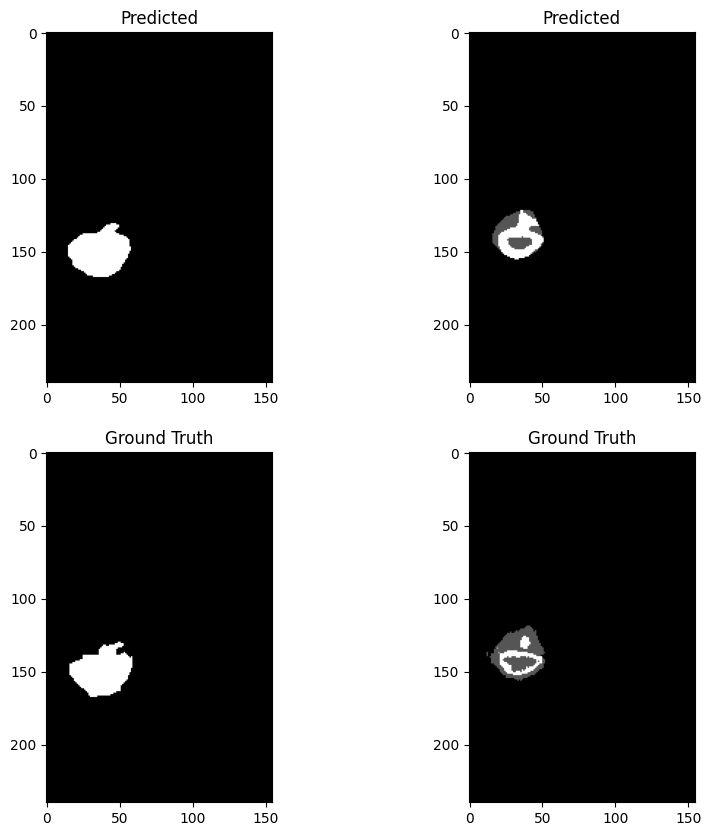

100%|██████████| 67/67 [02:38<00:00,  2.37s/it]


Average Validation Loss: 0.01975630537898683

Average Validation DSC: [0.99800543 0.81219483 0.85792035 0.56311881]
Average Validation ASSD: [ 0.21842581 25.65037572 31.29345721 42.32870715]
Epoch 14/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


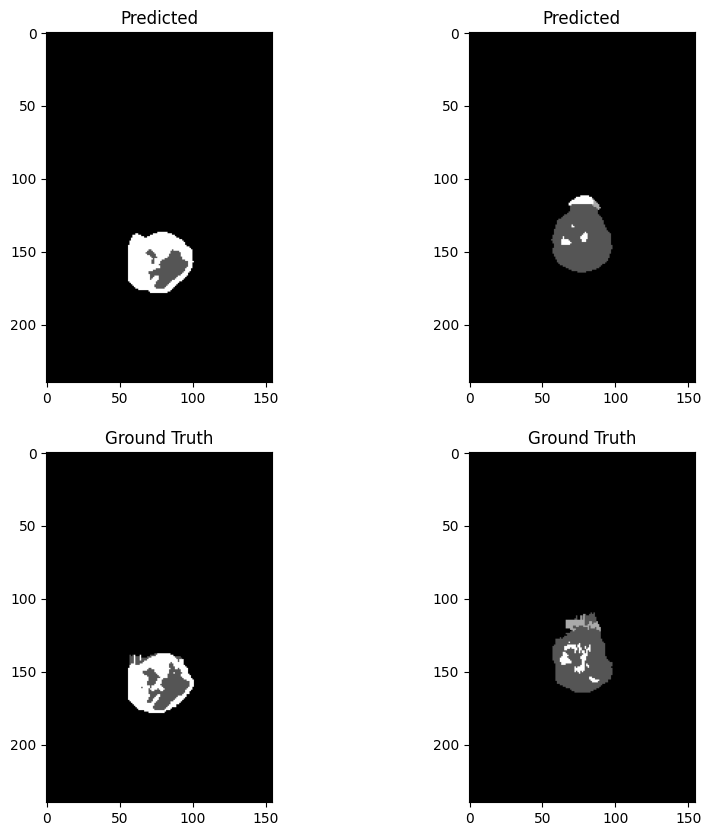

100%|██████████| 267/267 [11:15<00:00,  2.53s/it]



Average Training Loss: 0.017911443546107422

Average Training DSC: [0.99805586 0.80068108 0.88573235 0.57289687]
Average Training ASSD: [ 0.2041863  32.74966252 23.83346726 54.14483351]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


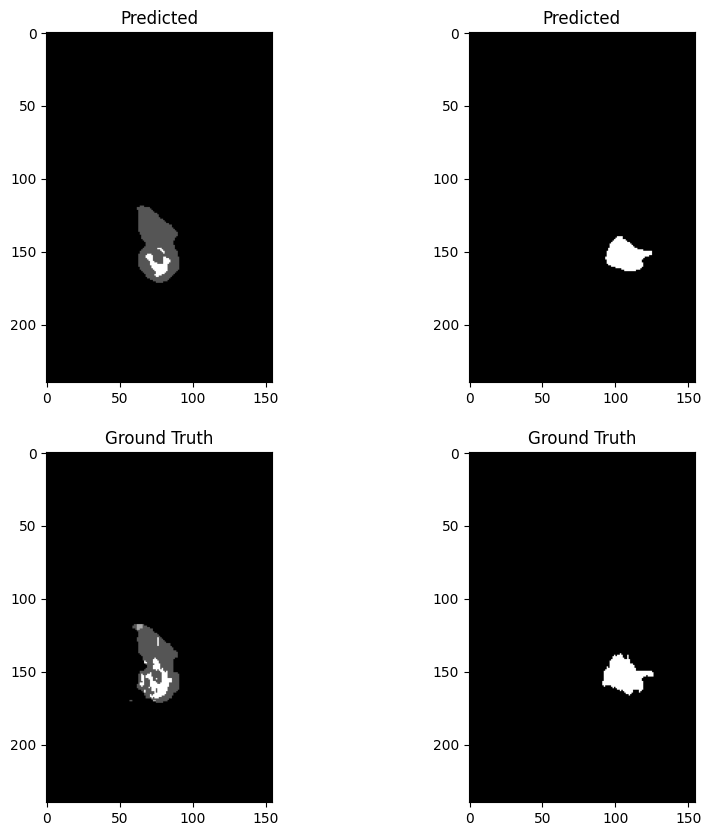

100%|██████████| 67/67 [02:35<00:00,  2.32s/it]


Average Validation Loss: 0.018830045863096393

Average Validation DSC: [0.99790884 0.79141549 0.84276368 0.54056581]
Average Validation ASSD: [ 0.23791463 34.17610031 36.340856   63.10557008]
Epoch 15/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


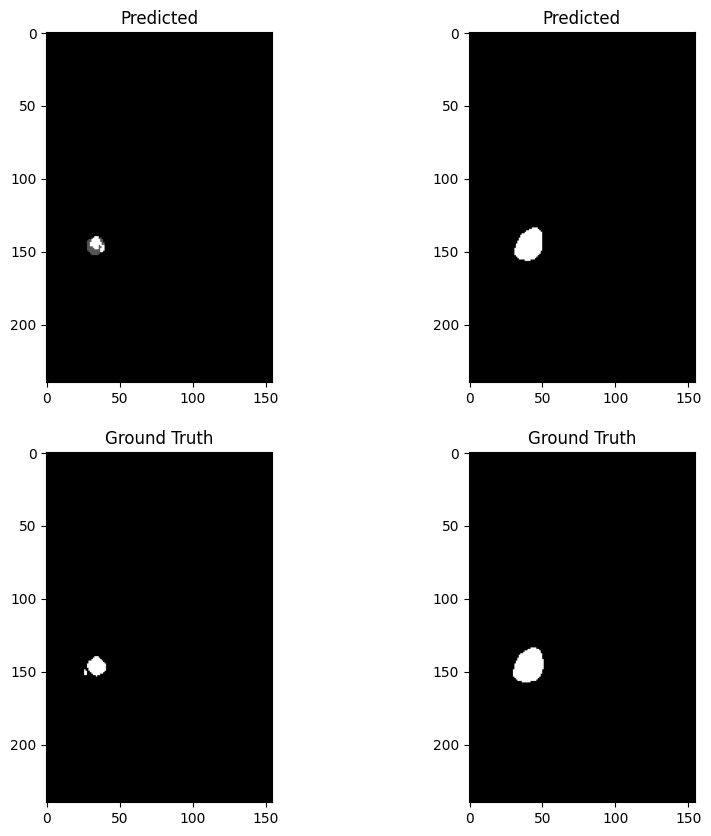

100%|██████████| 267/267 [11:30<00:00,  2.58s/it]



Average Training Loss: 0.016747756177482757

Average Training DSC: [0.99816136 0.81225577 0.89164195 0.58703233]
Average Training ASSD: [ 0.19045398 29.90670958 22.31436896 54.55198164]


  0%|          | 0/67 [00:00<?, ?it/s]

Validation Prediction Visualization:


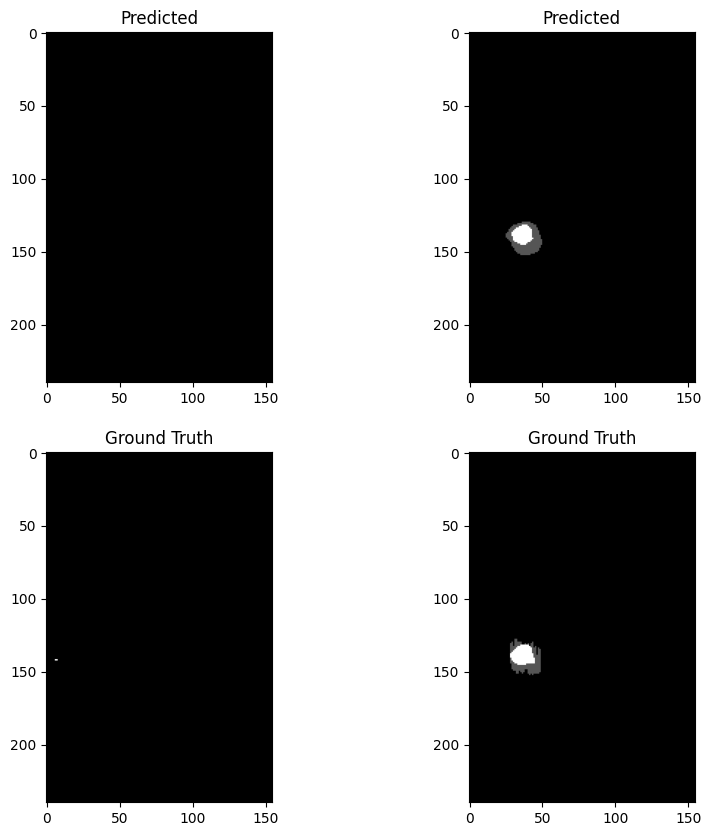

100%|██████████| 67/67 [02:44<00:00,  2.46s/it]


Average Validation Loss: 0.01649582793296718

Average Validation DSC: [0.99820987 0.82858278 0.88219875 0.58551348]
Average Validation ASSD: [ 0.18630995 25.22759224 26.04334033 50.80305338]
Epoch 16/50
-------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

Training Prediction Visualization:


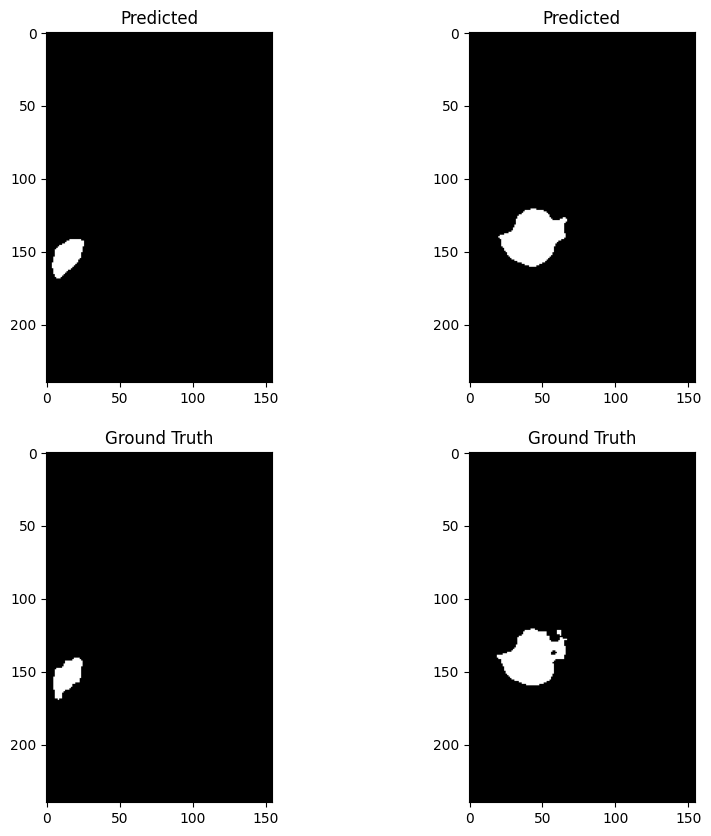

  7%|▋         | 18/267 [00:45<10:13,  2.46s/it]

In [ ]:
model = train_model(num_epochs = 50)